In [55]:
import pandas as pd

df = pd.read_csv('output.csv')
df.fillna(0, inplace= True)

In [56]:
# Data Cleaning
df.reset_index(inplace=True)
df.columns

Index(['index', 'text', 'user', 'Question', 'answered', 'answered_index'], dtype='object')

In [57]:
# calculate messages_after value
def answer_index(ind, answer_ind):
    if answer_ind <= 0:
        return 0
    return answer_ind - ind -2

In [58]:
df.columns = ['r_index', 'text', 'user', 'Question', 'answered', 'answered_index']

In [59]:
df['answer_offset'] = df.apply(lambda row : answer_index(int(row['r_index']), int(row['answered_index'])), axis = 1)

In [60]:
counter = df['answer_offset'].value_counts()

In [61]:
from collections import Counter

counter_dict = dict(counter)
del counter_dict[0]
counter = Counter(counter_dict)

In [62]:
print(type(counter))

<class 'collections.Counter'>


In [63]:
# Save counter object
import pickle
with open('../models/pdf.pickle', 'wb') as f:
    pickle.dump(counter, f)

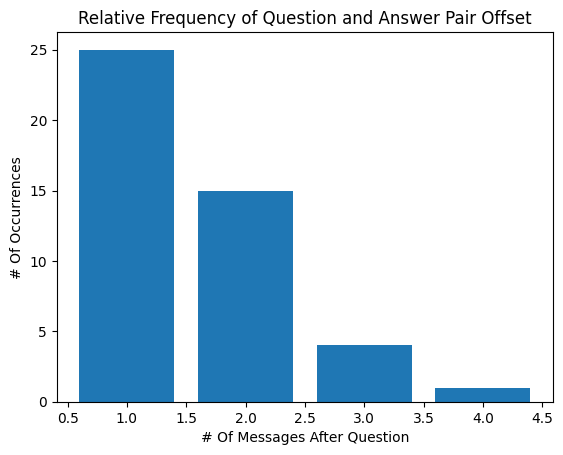

In [64]:
import matplotlib.pyplot as plt
# Convert counter to pandas Series for easier plotting
counter_series = pd.Series(counter)

# Create plot
plt.bar(counter_series.index, counter_series.values)

# Add labels and title
plt.xlabel('# Of Messages After Question')
plt.ylabel('# Of Occurrences')
plt.title('Relative Frequency of Question and Answer Pair Offset')

# Show plot
plt.show()

In [65]:
# Great, I have a pdf.
# Now use model 1 to predict if a sentence is a question
from nltk import word_tokenize
## Stemmer
# Tokenization and stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def tokenize_and_stem(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [66]:
import joblib

q_or_a_model = joblib.load('../models/q_or_no.pkl')
q_or_a_vect = joblib.load('../models/q_or_a_vectorizer.pkl')

In [67]:
# Create vec set
in_vec = df['text'].astype(str)
vectorized_input = q_or_a_vect.transform(in_vec)

In [68]:
preds = q_or_a_model.predict(vectorized_input)

In [69]:
df['Question'] = df['Question'].astype(int)

In [70]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(df['Question'], preds))
print("Classification Report:\n", classification_report(df['Question'], preds))

Accuracy: 0.828
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.90       412
           1       0.53      0.18      0.27        88

    accuracy                           0.83       500
   macro avg       0.69      0.57      0.59       500
weighted avg       0.79      0.83      0.79       500


# not so good on 1 recall-> This is identifying questions.

In [71]:
df['q_predicted'] = preds

In [72]:
df[(df['Question']== 0) &  (df['q_predicted']== 1)]

,r_index,text,user,Question,answered,answered_index,answer_offset,q_predicted
67,67,Integer is justa placeholder,Ander,0,0.0,0.0,0,1
164,164,https://www.github.com/pythondiscord/snekbox i...,Emperor,0,0.0,0.0,0,1
166,166,that's where the code is actually executed,Emperor,0,0.0,0.0,0,1
224,224,which I'll work up to tomorrow I work on nodes...,Yancarlos,0,0.0,0.0,0,1
244,244,not sure what you are representing,Antero,0,0.0,0.0,0,1
284,284,not sure which channel is best to talk about that,Ayviana,0,0.0,0.0,0,1
308,308,which one do i uninstall,Melodi,0,0.0,0.0,0,1
321,321,so you can use that to disambiguate which vers...,Ramon,0,0.0,0.0,0,1
332,332,Use `py 0` to see which versions are installed,Ramon,0,0.0,0.0,0,1
372,372,@Mrpolymath it looks like what you get when yo...,Dmazi,0,0.0,0.0,0,1


In [73]:
# Test Q pairing model with method 1- > OR
pair_model = joblib.load('../models/pair_model.pkl')
pair_vectorizer = joblib.load('../models/pair_vectorizer.pkl')

In [74]:
tf_idf_matrix = pair_vectorizer.transform(df['text'].astype(str))

In [75]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix)

In [76]:
def calculate_cosign_similarity(index_a, offset):
    if index_a + offset >= len(df):
        return 0
    return sim_matrix[index_a, index_a + offset]

In [77]:
df

,r_index,text,user,Question,answered,answered_index,answer_offset,q_predicted
0,0,networking is always one of the more complicat...,Antero,0,0.0,0.0,0,0
1,1,not usually fun kind of challange,Antero,0,0.0,0.0,0,0
2,2,so people don't usually answer those unless th...,Antero,0,0.0,0.0,0,0
3,3,I feel like a gif recording of you running it ...,Lica,0,0.0,0.0,0,0
4,4,Ok,Tiegan,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...
495,495,Beautiful Soup can do all the parsing you need,Eduard,0,0.0,0.0,0,0
496,496,I think I may have misunderstood the question ...,Eduard,0,0.0,0.0,0,0
497,497,Did my answer help?,Eduard,1,0.0,0.0,0,0
498,498,Ok I want something like this,Sayge,0,0.0,0.0,0,0


In [78]:
df['pair_1_sim'] = df['r_index'].apply(lambda x: calculate_cosign_similarity(int(x), 1))

In [79]:
df['pair_2_sim'] = df['r_index'].apply(lambda x: calculate_cosign_similarity(int(x), 2))

In [80]:
df['pair_3_sim'] = df['r_index'].apply(lambda x: calculate_cosign_similarity(int(x), 3))

In [81]:
df['pair_4_sim'] = df['r_index'].apply(lambda x: calculate_cosign_similarity(int(x), 1))

In [82]:
df

,r_index,text,user,Question,answered,answered_index,answer_offset,q_predicted,pair_1_sim,pair_2_sim,pair_3_sim,pair_4_sim
0,0,networking is always one of the more complicat...,Antero,0,0.0,0.0,0,0,0.019601,0.008150,0.011461,0.019601
1,1,not usually fun kind of challange,Antero,0,0.0,0.0,0,0,0.175093,0.015569,0.000000,0.175093
2,2,so people don't usually answer those unless th...,Antero,0,0.0,0.0,0,0,0.073177,0.000000,0.000000,0.073177
3,3,I feel like a gif recording of you running it ...,Lica,0,0.0,0.0,0,0,0.000000,0.000000,0.202352,0.000000
4,4,Ok,Tiegan,0,0.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,Beautiful Soup can do all the parsing you need,Eduard,0,0.0,0.0,0,0,0.009503,0.000000,0.000000,0.009503
496,496,I think I may have misunderstood the question ...,Eduard,0,0.0,0.0,0,0,0.000000,0.171351,0.000000,0.000000
497,497,Did my answer help?,Eduard,1,0.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000
498,498,Ok I want something like this,Sayge,0,0.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000


In [83]:
questions_only = df[df['Question'] == 1]
questions_only.drop(columns= ['r_index', 'user', 'answered_index', 'q_predicted'])

,text,Question,answered,answer_offset,pair_1_sim,pair_2_sim,pair_3_sim,pair_4_sim
13,Timer command I created (works 100%). How can ...,1,1.0,2,0.166391,0.000000,0.159706,0.166391
15,tell them to enter in seconds?,1,0.0,0,0.052875,0.000000,0.000000,0.052875
23,but I do not get how to detect the h as a hour...,1,1.0,1,0.073883,0.273593,0.040127,0.073883
28,why =?,1,0.0,0,0.000000,0.000000,0.000000,0.000000
33,```pythoneh = input('Enter a timer length'):if...,1,0.0,0,0.014275,0.000000,0.000000,0.014275
...,...,...,...,...,...,...,...,...
468,@lemon Sir can you help? please?,1,1.0,1,0.000000,0.195721,0.109929,0.000000
472,@lemon Hey can I ask a question?,1,1.0,1,0.000000,0.282298,0.360547,0.000000
480,Is there a reason why there is only python dis...,1,1.0,1,0.000000,0.276518,0.000000,0.000000
492,@dummy sorry for the ping can html parser can ...,1,1.0,1,0.014777,0.047676,0.283768,0.014777


In [84]:
offset_1 = df[['Question', 'pair_1_sim']]

In [85]:
offset_1.columns = ['Question', 'similarity']

In [86]:
offset_1_preds = pair_model.predict(offset_1[['similarity']])

In [87]:
offset_1['predicted'] = offset_1_preds

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\1333631988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offset_1['predicted'] = offset_1_preds


In [88]:
offset_1

,Question,similarity,predicted
0,0,0.019601,0
1,0,0.175093,1
2,0,0.073177,0
3,0,0.000000,0
4,0,0.000000,0
...,...,...,...
495,0,0.009503,0
496,0,0.000000,0
497,1,0.000000,0
498,0,0.000000,0


In [89]:
offset_2 = df[['Question', 'pair_2_sim']]
offset_2.columns = ['Question', 'similarity']
offset_2_preds = pair_model.predict(offset_2[['similarity']])
offset_2['predicted'] = offset_2_preds

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\230663001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offset_2['predicted'] = offset_2_preds


In [90]:
offset_3 = df[['Question', 'pair_3_sim']]
offset_3.columns = ['Question', 'similarity']
offset_3_preds = pair_model.predict(offset_2[['similarity']])
offset_3['predicted'] = offset_3_preds

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\1592016180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offset_3['predicted'] = offset_3_preds


In [91]:
offset_4 = df[['Question', 'pair_4_sim']]
offset_4.columns = ['Question', 'similarity']
offset_4_preds = pair_model.predict(offset_3[['similarity']])
offset_4['predicted'] = offset_4_preds

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\2562333875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offset_4['predicted'] = offset_4_preds


In [92]:
questions_only['pred_1'] = offset_1['predicted']
questions_only['pred_2'] = offset_2['predicted']
questions_only['pred_3'] = offset_3['predicted']
questions_only['pred_4'] = offset_4['predicted']

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\2597617169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_only['pred_1'] = offset_1['predicted']
C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\2597617169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_only['pred_2'] = offset_2['predicted']
C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\2597617169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [93]:
def any_of_4(int_1, int_2, int_3, int_4):
    if (int_1 + int_2 + int_3 + int_4) > 0:
        return 1
    return 0

In [94]:
questions_only['or_pred'] = questions_only[['pred_1', 'pred_2', 'pred_3', 'pred_4']].max(axis=1)

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\2492090521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_only['or_pred'] = questions_only[['pred_1', 'pred_2', 'pred_3', 'pred_4']].max(axis=1)


In [95]:
questions_only['or_pred']

13     1
15     0
23     1
28     0
33     0
      ..
468    1
472    1
480    1
492    1
497    0
Name: or_pred, Length: 88, dtype: int64

In [96]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluation
print("Model performance in identifying answered questions, known to be questions")
print("Accuracy:", accuracy_score(questions_only[questions_only['answered'], questions_only['or_pred']))
print("Classification Report:\n", classification_report(questions_only['answered'], questions_only['or_pred']))

Model performance in identifying answered questions
Accuracy: 0.625
Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.72      0.65        43
         1.0       0.67      0.53      0.59        45

    accuracy                           0.62        88
   macro avg       0.63      0.63      0.62        88
weighted avg       0.63      0.62      0.62        88


In [97]:
# Now try with pdf.

In [98]:
offset_1 = df[['Question', 'pair_1_sim']]
offset_1.columns = ['Question', 'similarity']
offset_1_preds = pair_model.predict_proba(offset_1[['similarity']])
offset_1['predicted'] = offset_1_preds[:, 1]

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\1138612929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offset_1['predicted'] = offset_1_preds[:, 1]


In [99]:
offset_2 = df[['Question', 'pair_2_sim']]
offset_2.columns = ['Question', 'similarity']
offset_2_preds = pair_model.predict_proba(offset_2[['similarity']])
offset_2['predicted'] = offset_2_preds[:, 1]

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\735901569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offset_2['predicted'] = offset_2_preds[:, 1]


In [100]:
offset_3 = df[['Question', 'pair_3_sim']]
offset_3.columns = ['Question', 'similarity']
offset_3_preds = pair_model.predict_proba(offset_3[['similarity']])
offset_3['predicted'] = offset_3_preds[:, 1]

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\3719411754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offset_3['predicted'] = offset_3_preds[:, 1]


In [101]:
offset_4 = df[['Question', 'pair_4_sim']]
offset_4.columns = ['Question', 'similarity']
offset_4_preds = pair_model.predict_proba(offset_4[['similarity']])
offset_4['predicted'] = offset_4_preds[:, 1]

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\628293489.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offset_4['predicted'] = offset_4_preds[:, 1]


In [102]:
questions_only['pred_1'] = offset_1['predicted']
questions_only['pred_2'] = offset_2['predicted']
questions_only['pred_3'] = offset_3['predicted']
questions_only['pred_4'] = offset_4['predicted']

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\2597617169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_only['pred_1'] = offset_1['predicted']
C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\2597617169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_only['pred_2'] = offset_2['predicted']
C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\2597617169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [103]:
questions_only

,r_index,text,user,Question,answered,answered_index,answer_offset,q_predicted,pair_1_sim,pair_2_sim,pair_3_sim,pair_4_sim,pred_1,pred_2,pred_3,pred_4,or_pred
13,13,Timer command I created (works 100%). How can ...,Falah,1,1.0,17.0,2,0,0.166391,0.000000,0.159706,0.166391,0.530621,0.196000,0.515247,0.530621,1
15,15,tell them to enter in seconds?,Antero,1,0.0,0.0,0,0,0.052875,0.000000,0.000000,0.052875,0.284148,0.196000,0.196000,0.284148,0
23,23,but I do not get how to detect the h as a hour...,Falah,1,1.0,26.0,1,0,0.073883,0.273593,0.040127,0.073883,0.325132,0.752324,0.260858,0.325132,1
28,28,why =?,Falah,1,0.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.196000,0.196000,0.196000,0.196000,0
33,33,```pythoneh = input('Enter a timer length'):if...,Falah,1,0.0,0.0,0,0,0.014275,0.000000,0.000000,0.014275,0.217573,0.196000,0.196000,0.217573,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,468,@lemon Sir can you help? please?,Valentine,1,1.0,471.0,1,0,0.000000,0.195721,0.109929,0.000000,0.196000,0.597020,0.401808,0.196000,1
472,472,@lemon Hey can I ask a question?,Eduard,1,1.0,475.0,1,0,0.000000,0.282298,0.360547,0.000000,0.196000,0.766975,0.871329,0.196000,1
480,480,Is there a reason why there is only python dis...,Eduard,1,1.0,483.0,1,0,0.000000,0.276518,0.000000,0.000000,0.196000,0.757314,0.196000,0.196000,1
492,492,@dummy sorry for the ping can html parser can ...,Sayge,1,1.0,495.0,1,0,0.014777,0.047676,0.283768,0.014777,0.218361,0.274499,0.769388,0.218361,1


In [104]:
def pdf_prediction(num1, num2, num3, num4):
    n = sum(counter.values())
    pdf_1 = num1 * (counter[1]/n)
    pdf_2 = num2 * (counter[2]/n)
    pdf_3 = num3 * (counter[3]/n)
    pdf_4 = num4 * (counter[4]/n)
    ev = pdf_1 + pdf_2 + pdf_3 + pdf_4
    if ev >= 0.5:
        return 1
    return 0

In [105]:
questions_only['pdf_pred'] = questions_only.apply(lambda row: pdf_prediction(row['pred_1'], row['pred_2'], row['pred_3'], row['pred_4']), axis=1)

C:\Users\Cam\AppData\Local\Temp\ipykernel_10780\2349241197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_only['pdf_pred'] = questions_only.apply(lambda row: pdf_prediction(row['pred_1'], row['pred_2'], row['pred_3'], row['pred_4']), axis=1)


In [106]:
questions_only['pdf_pred'].describe()

count    88.000000
mean      0.147727
std       0.356863
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: pdf_pred, dtype: float64

In [107]:

print("Model performance on conversational training data in identifying answered questions using train PDF")
print("Accuracy:", accuracy_score(questions_only['answered'], questions_only['pdf_pred']))
print("Classification Report:\n", classification_report(questions_only['answered'], questions_only['pdf_pred']))

Model performance on conversational training data in identifying answered questions using train PDF
Accuracy: 0.5227272727272727
Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.88      0.64        43
         1.0       0.62      0.18      0.28        45

    accuracy                           0.52        88
   macro avg       0.56      0.53      0.46        88
weighted avg       0.56      0.52      0.46        88
